In [69]:
# imports
from random import randint
import numpy as np
import random
import datetime # for limiting calculation to wall clock time
import math
import copy
import matplotlib.pyplot as plt


In [70]:
# # game class
class TigerProblem():
    def __init__(self,obs_truth = 0.85):
#         self.state = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
        self.obs_truth = obs_truth # how much you can trust observations
        self.all_states = set(['tiger-left','tiger-right'])
        # |A| x |S| x |O| matrix
        self.O = np.array([
                    [[obs_truth, 1-obs_truth], [1-obs_truth, obs_truth]],
                    [[0.5, 0.5], [0.5, 0.5]],
                    [[0.5, 0.5], [0.5, 0.5]]
                    ])
        # |A| x |S| x |S'| matrix, for tiger problem this is 3 x 2 x 2
        self.T = np.array([
                    [[1.0, 0.0], [0.0, 1.0]],
                    [[0.5, 0.5], [0.5, 0.5]],
                    [[0.5, 0.5], [0.5, 0.5]]
                    ])
        # |A| x |S| matrix
        self.R = np.array([
                    [-1., -1.],
                    [-20.0, 10.0],
                    [10.0, -20.0]
                    ])
        #prior belief in the game over the two states
        self.prior = [0.5,0.5]
        self.all_actions = ['listen','open-left','open-right']
        self.statelist = ['tiger-left','tiger-right']
        
    # this contains the transition function for the MDP
    def next_state(self, state, action):
        
        assert action in ['listen','open-left','open-right'], "invalid action"
        
        if action == 'listen':
            return state
        elif action == 'open-left':
            return ('tiger-left' if random.random() < 0.5 else 'tiger-right')
        elif action == 'open-right':            
            return ('tiger-left' if random.random() < 0.5 else 'tiger-right')
       
    # observation function for the POMDP
    def observation(self, state, action):  
        
        assert action in ['listen','open-left','open-right'], "invalid action"
        
        all_s = self.all_states
        
        if action == 'listen':
            if random.random() < self.obs_truth:
                return state
            else:
                other = [st for st in self.all_states if st != state]
                return other[0]
        else:
#             return []
            if random.random() < 0.5:
                return state
            else:
                other = [st for st in self.all_states if st != state]
                return other[0]
        
    # Take a sequence of game states representing the full game tree, and return the full list
    # of actions that are legal actions
    def legal_actions(self,state_hist): 
        return ['listen','open-left','open-right']
    
    # Should this be the length of state_tree (how long tama alive for)? or is it trial by trial rwd?
    def reward(self, state, action):
        if action == 'listen':
            return -1
        elif action == 'open-left':
            return -20 if state == 'tiger-left' else 10
        elif action == 'open-right':            
            return -20 if state == 'tiger-right' else 10
            
    # GENERATOR MODEL OF GAME
    # returns next state, observation, and reward given an action taken in given state
    # takes tuple state
    def G_model(self,state,action):
        s = self.next_state(state,action)
        obs = self.observation(state,action)
        rwd = self.reward(state,action) # note that this should be more like immediate reward of state, not long-term?
        done = False
        return s, obs, rwd, done
    
    # Initial state distribution
    # Initial state distribution
    def sample_prior(self):
        s = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
        return s
    
    # UPDATE BELIEF DIRECTLY USING OBSERVATION AND TRANSITION MATRICES
    # oldb is old belief, action is action taken, obs is observation made
    def update_belief(self,oldb,action,obs):
        # translate to indices a and o 
        o = self.statelist.index(obs) if obs in self.statelist else []
        a = self.all_actions.index(action)
        
        #init b
        b = [0,0]
        
        # set b
        b[1] = self.O[a,1,o]*(self.T[a,0,1]*oldb[0] + self.T[a,1,1]*oldb[1])
        b[0] = self.O[a,0,o]*(self.T[a,0,0]*oldb[0] + self.T[a,1,0]*oldb[1])
        b = b/(b[0] + b[1])
        return b
        
#     # when filtering particles, this is the rule to keep one given a real observation
#     def keep_particle(self, part, real_obs):
#         trash_prob = 0.8
#         if real_obs == []:
#             return True
#         if part != real_obs and random.random() < trash_prob:
#             return False
#         return True

#     #     if real_obs == []:
#     #         return True
#     #     else:
#     #         if part == real_obs:
#     #             return True
#     #     return False

#     # generate a new particle from one randomly sampled from current belief (e.g., just add a lil noise)
#     def new_particle(self, part):
#         s = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
#         return s

In [109]:
class SearchTree(object):
    def __init__(self,visits=1,value=0):
        self.visits = visits
        self.value = value
        self.label = []
        self.children=[]
        
    def print_tree(self, level=0, max = 6):
        print('\t' * level + repr(self.label) + ' val:' + repr(self.value) + ' visits:' + repr(self.visits))
        if isinstance(self,ObservationNode):
            print('\t' * level + repr(self.belief))
        if level < max:  
            for child in self.children:
                child.print_tree(level+1)
    
class ActionNode(SearchTree):
    def __init__(self,action=None,visits=1,value=0):
        super().__init__(visits,value)
        self.action = action
        self.label = action
        
        
class ObservationNode(SearchTree):
    def __init__(self,observation=[],visits=1,value=0,belief=[0.5,0.5]): # *** how to init belief?
        super().__init__(visits,value)
        self.observation = observation
        self.label = observation
        self.belief = belief
        
    def expand(self, legal_actions):
        for a in legal_actions:
            self.children += [ActionNode(a)]
            
        # upper confidence bound value for given node "child"
    def ucb(self, child): #maybe use index of child not object
#         print("self.visit=",self.visit," len of self.children=",len(self.children))
        logval = math.log(self.visits) #, len(self.children))
        div = logval / child.visits
        return math.sqrt(div)
    
#     def sample_belief(self):
#         return random.choice(self.belief)
    
    
    # ***** This gonna need some work - cuz obs nodes are initialized without specified prior
    def next_hist(self,action,obs):
        act_child = next((c for c in self.children if c.action==action), None)
        assert act_child != None, "shouldn't you be expanded already?"
        assert isinstance(act_child, ActionNode), "action child should be an action node!"
        
        obs_child = next((c for c in act_child.children if c.observation == obs), None) 
        if obs_child is None:
            act_child.children += [ObservationNode(obs)]
#             print(act_child.children[0].observation)
            obs_child = next((c for c in act_child.children if c.observation == obs), None)     
        return obs_child
    
#     def next_hist_rollout(self,action,obs):

In [115]:
class POMCP:
    def __init__(self, 
                 game=TigerProblem(),
                 discount=0.8,
                 explore=1,
                 epsilon=1e-7,
#                  n_particles=100,
#                  reinvigoration=20, 
                 **kwargs):
        
#         self.context = {}
        self.game = game
        self.discount = discount
        self.epsilon = epsilon
        self.explore = explore
#         self.n_particles = n_particles
#         self.reinvigoration = reinvigoration
        self.G = game.G_model      
        self.tree = None
        self.history = []
        # list of all possible actions
#         self.actions = kwargs.get('actions') 
        
        seconds = kwargs.get('time',30)
        self.calculation_time = datetime.timedelta(seconds=seconds)
        self.maxdepth = kwargs.get('maxdepth',20)
        self.nsims = kwargs.get('nsims',1000)
        
    def search(self,obs):
        
        self.history += [obs]
        
        if self.tree is None:
            self.tree = ObservationNode(obs)                        
#             particle = self.game.sample_prior()
#             self.simulate(particle,self.tree,0)
        else:
#             a = self.tree.action
            self.prune_tree(obs) #maybe also want to directly update belief here?
            
            
        for _ in range(self.nsims):
            particle = self.draw_sample() # so i could do it here, where particle is drawn from belief?
            self.simulate(particle,self.tree,0)
        
        child = self.greedy_action_selection(self.tree,self.game.legal_actions(self.tree)) # will again need to handle legal actions differently for real
        self.tree = child # move forward to child action node (will move to obs node when real obs occurs)
        self.history += [child.action]
        
        return child.action
    
    def simulate(self,state,tree,depth):
        if depth >= self.maxdepth:
            return 0
        
#         legal = self.game.legal_actions(state,tree,depth)
        legal = self.game.legal_actions(tree) # would want it to be more elegant/complicated for real
    
        if len(tree.children) == 0:
            tree.expand(legal)
            return self.rollout(state,depth)
        
        if len(legal)==1:
            action = legal[0]
            child = tree.children[0]
        else:
            child = self.ucb_action_selection(tree,legal)
            action = child.action
            
        next_state, next_obs, r, done = self.G(state,action)
        next_tree = tree.next_hist(action,next_obs)
        reward = r + self.discount * self.simulate(next_state,next_tree,depth+1)
        
#         print(tree.belief)
#         print(action)
#         print(next_obs)
        # BELIEF UPD8 HERE %^$^##$&@^#$(#@^$#@)$*(#&%)(@#$%&*)!#$(*^!#)%$(*#&$%)(@%)*(^)
#         tree.belief = self.game.update_belief(tree.belief,action,next_obs) # ummmmmm?????? will this work where else do i need to...???
#         tree.belief += [state] 
        tree.visits += 1
        
        child.visits += 1
        child.value += (reward - child.value)/child.visits
        
        return reward
    
    def rollout(self,state,depth):
        if depth >= self.maxdepth:
            return 0
        
        legal = self.game.legal_actions(["whatever but change this later"])
        a = random.choice(legal)
        
        next_state, next_obs, r, done = self.G(state,a)
#         next_tree = tree.next_hist(a,next_obs)
        
        if done:
            return r
        
        return r + self.discount * self.rollout(next_state,depth+1)
        
    def prune_tree(self,obs):
        #current tree is an action node. find child node with observation obs
        a = self.tree.action # temp holding for this 
        obs_child = next((c for c in self.tree.children if c.observation == obs), None) 
        self.tree = obs_child # now, root of tree is observation node (child of action node taken)
        self.tree.belief = self.game.update_belief(self.tree.belief,a,obs)
        return
        
    def greedy_action_selection(self,tree,legal):
        children = [child for child in tree.children if child.action in legal] #filter(lambda child: child.action in legal_actions, tree.children)
        child_vals = np.array([child.value for child in children])
        favechildren = np.argwhere(child_vals == np.amax(child_vals))
        child = children[random.choice(favechildren.flatten().tolist())]
        return child
        
    def ucb_action_selection(self,tree,legal):
        children = [child for child in tree.children if child.action in legal] #filter(lambda child: child.action in legal_actions, tree.children)
        child_vals = np.array([child.value + self.explore * tree.ucb(child) for child in children])
        favechildren = np.argwhere(child_vals == np.amax(child_vals))
        child = children[random.choice(favechildren.flatten().tolist())]
        return child
    
    def draw_sample(self):
#         if self.tree.belief == []: #self.tree.belief == []: # is this part necessary now? how to fix
#             return self.game.sample_prior()
#         else:
        return ('tiger-left' if random.random() < self.tree.belief[0] else 'tiger-right')# random.choice(self.tree.belief)

In [116]:
s = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
game = TigerProblem()
agent = POMCP(game, 0.9, maxdepth=20, nsims=1000)


In [117]:

# Check that the tree runs simulations to choose the next action using the choose_move() method

print("INITIAL STATE: ")
print(s) # initial tiger problem state

obs = []

action = agent.search(obs)
print("Taking action:", action)
state = game.next_state(s,action)
game.reward(s,action)

INITIAL STATE: 
tiger-right
Taking action: listen


-1

In [119]:
# if next obs is tiger-left,
observeright = 1 #1 if observes right on next observation, 0 if observes left
# belief = len(agent.tree.children[observeright].belief)
# nleftbelief = len([b for b in agent.tree.children[observeright].belief if b=='tiger-left'])
# nrightbelief = len([b for b in agent.tree.children[observeright].belief if b=='tiger-right'])
print(['left belief:',agent.tree.children[observeright].belief[0]])
print(['right belief:',agent.tree.children[observeright].belief[1]])
# print(['left belief percentage:',nleftbelief/nparticles])

['left belief:', 0.5]
['right belief:', 0.5]


In [120]:
# hey that looks better but shouldn't it have changed after observation?
# agent.tree.children[1].children[0].children[1].children[1].children

agent.tree.print_tree()

'listen' val:-16.10699551619546 visits:970
	'tiger-right' val:0 visits:490
	[0.5, 0.5]
		'listen' val:-13.375660542065516 visits:483
			'tiger-right' val:0 visits:376
			[0.5, 0.5]
				'listen' val:-23.298960642785822 visits:4
					'tiger-right' val:0 visits:3
					[0.5, 0.5]
						'listen' val:-36.07106013871301 visits:2
						'open-left' val:-4.158420970762567 visits:2
						'open-right' val:0 visits:1
				'open-left' val:-9.621564325731605 visits:372
					'tiger-left' val:0 visits:190
					[0.5, 0.5]
						'listen' val:-21.467153711902764 visits:173
						'open-left' val:-32.5896554690372 visits:16
						'open-right' val:-35.15534075126607 visits:3
					'tiger-right' val:0 visits:181
					[0.5, 0.5]
						'listen' val:-15.165595230097676 visits:141
						'open-left' val:-31.52112497900815 visits:39
						'open-right' val:-38.21019235619914 visits:3
				'open-right' val:-44.6213592202281 visits:2
					'tiger-left' val:0 visits:1
					[0.5, 0.5]
						'listen' val:0 visits:1
						'op

In [96]:
# Now, let the POMCP do its thing for several actions in a row

# Initialize the tiger problem
s = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
game = TigerProblem(1.0) #obs_truth=0.95)
    
print("INITIAL STATE: ")
print(s) # initial tiger state

agent = POMCP(game, 0.9, maxdepth=20, nsims=1000)

action_seq = []
state = s
obs = []
R = 0


while len(action_seq) <= 20: # play for a certain amount of time (better rule?)

    action = agent.search(obs)
    action_seq.append(action)
    print('Action %i: True state is %s'% (len(action_seq), state))
    print("Taking action %s."% action)
    
    obs = game.observation(state,action)
    if obs!=[]:
        print("observed ",obs)

    r = game.reward(state,action)
    R = R + r
    print("Reward so far: ",R)    
    
    state = game.next_state(state,action)
    

    
print("game over!")

In [121]:
# now let's compare the performance of different nsims n

# storeobservations = []
# storeactions = []
# storerewards = []
ns = [10, 100, 500, 1000, 5000, 6000, 7000, 8000, 9000, 10000]
c = 1

allobs, allacts, allrewards = [], [], []
nreps = 1

for n in ns:
    print("nsims = ", n)
    storeobservations, storeactions, storerewards = [], [], []
    
    for rep in range(nreps):
        print("rep ",rep)
        if game:
            del game
            del agent
        # Initialize the tiger
        s = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
        game = TigerProblem(1.0) #obs_truth=0.95)

#         print("INITIAL STATE: ")
#         print(s) # initial tiger state

        agent = POMCP(game, 0.9, c, maxdepth=20, nsims=n)

        action_seq = []
        obs_seq = []
        state = s
        obs = []
        R = 0


        while len(action_seq) <= 20: # play for a certain amount of time (better rule?)

            action = agent.search(obs)
            action_seq.append(action)
#             print('Action %i: True state is %s'% (len(action_seq), state))
#             print("Taking action %s."% action)

            obs = game.observation(state,action)
            obs_seq.append(obs)

#             if obs!=[]:
#                 print("observed ",obs)

            r = game.reward(state,action)
            R = R + r
#             print("Reward so far: ",R)    

            state = game.next_state(state,action)

        
        storeobservations.append([obs_seq])
        storeactions.append([action_seq])
        storerewards.append(R)
        print("game over! reward ",R)
        
    allobs.append([storeobservations])
    allacts.append([storeactions])
    allrewards.append([storerewards])

nsims =  10
rep  0
game over! reward  16
nsims =  100
rep  0
game over! reward  59
nsims =  500
rep  0
game over! reward  70
nsims =  1000
rep  0
game over! reward  10
nsims =  5000
rep  0
game over! reward  70
nsims =  6000
rep  0
game over! reward  48
nsims =  7000
rep  0
game over! reward  89
nsims =  8000
rep  0
game over! reward  78
nsims =  9000
rep  0
game over! reward  70
nsims =  10000
rep  0
game over! reward  59


In [122]:
print(ns)
print(allrewards)
rwds = np.array(allrewards)
print(np.mean(rwds,axis=2))

[10, 100, 500, 1000, 5000, 6000, 7000, 8000, 9000, 10000]
[[[16]], [[59]], [[70]], [[10]], [[70]], [[48]], [[89]], [[78]], [[70]], [[59]]]
[[16.]
 [59.]
 [70.]
 [10.]
 [70.]
 [48.]
 [89.]
 [78.]
 [70.]
 [59.]]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


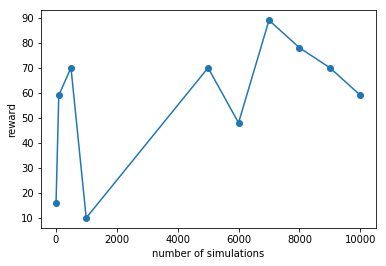

In [123]:
cashmoney = np.mean(rwds,axis=2) 
cashmoney_ste = np.std(rwds,axis=2)/np.sqrt(nreps)
bars = cashmoney_ste.reshape([len(ns),1])[:,0]
print(bars)
plt.plot(ns,cashmoney,'o-')
plt.errorbar(ns,cashmoney,yerr=bars,xerr=None,fmt='none')
plt.xlabel("number of simulations")
plt.ylabel("reward")
plt.show()

In [125]:
# now let's compare the performance of different nsims n

# storeobservations = []
# storeactions = []
# storerewards = []
ns = [50, 100, 250, 500, 750, 1000, 2500, 5000, 10000]
c = 1

allobs, allacts, allrewards = [], [], []
nreps = 10

for n in ns:
    print("nsims = ", n)
    storeobservations, storeactions, storerewards = [], [], []
    
    for rep in range(nreps):
        print("rep ",rep)
        if game:
            del game
        if agent:
            del agent
        # Initialize the tiger
        s = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
        game = TigerProblem(0.85) #obs_truth=0.95)

#         print("INITIAL STATE: ")
#         print(s) # initial tiger state

        agent = POMCP(game, 0.9, c, maxdepth=20, nsims=n)

        action_seq = []
        obs_seq = []
        state = s
        obs = []
        R = 0


        while len(action_seq) <= 20: # play for a certain amount of time (better rule?)

            action = agent.search(obs)
            action_seq.append(action)
#             print('Action %i: True state is %s'% (len(action_seq), state))
#             print("Taking action %s."% action)

            obs = game.observation(state,action)
            obs_seq.append(obs)

#             if obs!=[]:
#                 print("observed ",obs)

            r = game.reward(state,action)
            R = R + r
#             print("Reward so far: ",R)    

            state = game.next_state(state,action)

        
        storeobservations.append([obs_seq])
        storeactions.append([action_seq])
        storerewards.append(R)
        print("game over! reward ",R)
        
    allobs.append([storeobservations])
    allacts.append([storeactions])
    allrewards.append([storerewards])

nsims =  50
rep  0
game over! reward  -140
rep  1
game over! reward  70
rep  2
game over! reward  10
rep  3
game over! reward  43
rep  4
game over! reward  -69
rep  5
game over! reward  29
rep  6
game over! reward  -39
rep  7
game over! reward  -80
rep  8
game over! reward  -39
rep  9
game over! reward  37
nsims =  100
rep  0
game over! reward  -20
rep  1
game over! reward  21
rep  2
game over! reward  -39
rep  3
game over! reward  48
rep  4
game over! reward  10
rep  5
game over! reward  37
rep  6
game over! reward  40
rep  7
game over! reward  59
rep  8
game over! reward  -102
rep  9
game over! reward  7
nsims =  250
rep  0
game over! reward  37
rep  1
game over! reward  48
rep  2
game over! reward  48
rep  3
game over! reward  51
rep  4
game over! reward  48
rep  5
game over! reward  29
rep  6
game over! reward  56
rep  7
game over! reward  -4
rep  8
game over! reward  56
rep  9
game over! reward  40
nsims =  500
rep  0
game over! reward  48
rep  1
game over! reward  -47
rep  2
game

In [127]:
print(ns)
print(allrewards)
rwds = np.array(allrewards)
print(np.mean(rwds,axis=2))

[50, 100, 250, 500, 750, 1000, 2500, 5000, 10000]
[[[-140, 70, 10, 43, -69, 29, -39, -80, -39, 37]], [[-20, 21, -39, 48, 10, 37, 40, 59, -102, 7]], [[37, 48, 48, 51, 48, 29, 56, -4, 56, 40]], [[48, -47, -80, -31, 67, -1, 48, -4, -1, 29]], [[10, 29, -34, 7, 7, 10, 10, 26, -9, 18]], [[48, 7, -1, 37, -12, 29, 18, -12, 78, -12]], [[21, 70, 40, 78, 48, 2, 10, 37, 40, 51]], [[-28, -12, -1, -1, -1, 7, 37, -20, -61, 40]], [[29, 21, 48, -50, 48, 18, 37, 59, 18, 51]]]
[[-17.8]
 [  6.1]
 [ 40.9]
 [  2.8]
 [  7.4]
 [ 18. ]
 [ 39.7]
 [ -4. ]
 [ 27.9]]


[19.92325275 14.59345744  5.36926438 13.94546521  5.4114693   9.0354856
  7.2402348   8.89381808  9.33000536]


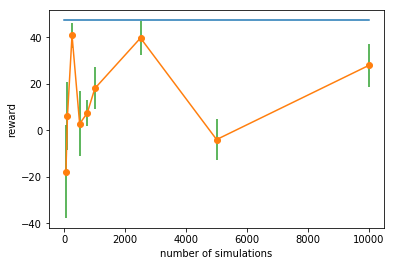

In [129]:
cashmoney = np.mean(rwds,axis=2) 
cashmoney_ste = np.std(rwds,axis=2)/np.sqrt(nreps)
bars = cashmoney_ste.reshape([len(ns),1])[:,0]
print(bars)
plt.plot([0,10000],[47.34,47.34],'-')
plt.plot(ns,cashmoney,'o-')
plt.errorbar(ns,cashmoney,yerr=bars,xerr=None,fmt='none')
plt.xlabel("number of simulations")
plt.ylabel("reward")
plt.show()

In [139]:
random.choice([0,1,2])

2